# Preprocesamiento de datos
Este notebook se encarga de:
1. Cargar los datos limpios (no normalizados)
2. Dividir el conjunto de datos en:
   - Conjunto de entrenamiento (80%)
   - Conjunto de prueba (20%)
3. Normalizar los datos usando estadísticas SOLO del conjunto de entrenamiento
4. Guardar los conjuntos normalizados y los parámetros de normalización

- Recreamos la función 'train_test_split' de la librería 'sklearn' en el archivo 'utils/preprocessing_functions.py'.
- Esta función permite dividir los datos en conjuntos: entrenamiento y prueba (train and test) de forma estratificada.
- La estratificación permite mantener el porcentaje de categorías 'M' y 'B' en ambos conjuntos, asegurando una representación equilibrada de los datos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys

# Configura el estilo de visualización
plt.style.use('ggplot')
%matplotlib inline

# Añadir el directorio raíz al path para poder importar módulos personalizados
sys.path.append('..')
from utils.config import FEATURE_NAMES, RANDOM_STATE, STRATIFY
from utils.preprocessing_functions import train_test_split

In [2]:
# Imprimir el valor para verificar
print(f"Valor de STRATIFY en config.py: {STRATIFY}")

Valor de STRATIFY en config.py: False


## 1. Carga de datos limpios (no normalizados)

In [3]:
print("Cargando datos limpios (no normalizados)...")
df = pd.read_csv('../data/processed/cleaned_data.csv')
print(f"Dimensiones del dataset: {df.shape}")
print(f"Primeras 5 filas del dataset:")
df.head()

Cargando datos limpios (no normalizados)...
Dimensiones del dataset: (569, 31)
Primeras 5 filas del dataset:


,diagnosis,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Análisis rápido de los datos cargados

In [4]:
print("Información del dataset:")
df.info()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   diagnosis  569 non-null    int64  
 1   f01        569 non-null    float64
 2   f02        569 non-null    float64
 3   f03        569 non-null    float64
 4   f04        569 non-null    float64
 5   f05        569 non-null    float64
 6   f06        569 non-null    float64
 7   f07        569 non-null    float64
 8   f08        569 non-null    float64
 9   f09        569 non-null    float64
 10  f10        569 non-null    float64
 11  f11        569 non-null    float64
 12  f12        569 non-null    float64
 13  f13        569 non-null    float64
 14  f14        569 non-null    float64
 15  f15        569 non-null    float64
 16  f16        569 non-null    float64
 17  f17        569 non-null    float64
 18  f18        569 non-null    float64
 19  f19        569 non-null  

# 3. Dividir los datos en conjuntos de entrenamiento y test
Los datos de prueba (test) los utiizaremos en la fase de predicción para evaluar la precisión del entrenamiento.

Dividiendo los datos en conjuntos de entrenamiento y prueba...
Valor de stratify en la función: False
Sin estratificación, división completamente aleatoria
Tamaño conjunto de entrenamiento: 456 muestras (80% del total)
Tamaño conjunto de prueba:	  113 muestras (20% del total)

Distribución de clases en cada conjunto:
Entrenamiento:  {0: 291, 1: 165}
Prueba: 	{0: 66, 1: 47}


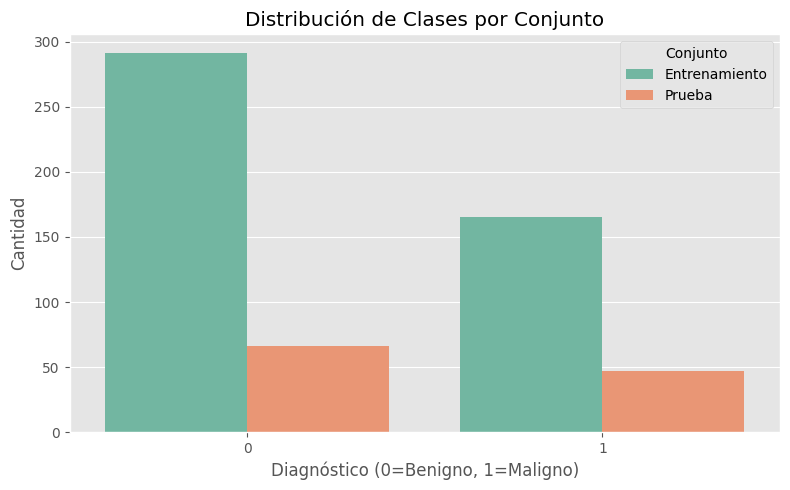

In [5]:
print("Dividiendo los datos en conjuntos de entrenamiento y prueba...")

# Separar características (X) y etiquetas (y)
X = df.drop('diagnosis', axis=1)    # todas las columnas salvo 'diagnosis'
y = df['diagnosis']                 # la variable dependiente es 'diagnosis'

# División: 80% para entrenamiento, 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                  random_state=RANDOM_STATE, 
                                                  stratify=STRATIFY)

print(f"Tamaño conjunto de entrenamiento: {len(X_train)} muestras ({len(X_train)/len(df):.0%} del total)")
print(f"Tamaño conjunto de prueba:\t  {len(X_test)} muestras ({len(X_test)/len(df):.0%} del total)")

# Verificar la distribución de clases en cada conjunto
print("\nDistribución de clases en cada conjunto:")
print(f"Entrenamiento:  {y_train.value_counts().to_dict()}")
print(f"Prueba: \t{y_test.value_counts().to_dict()}")

# Gráfico de distribución de clases por conjunto
# Crear un DataFrame largo para usar con seaborn
class_dist = []
for label, count in y_train.value_counts().items():
    class_dist.append({'Diagnóstico': label, 'Conjunto': 'Entrenamiento', 'Cantidad': count})
for label, count in y_test.value_counts().items():
    class_dist.append({'Diagnóstico': label, 'Conjunto': 'Prueba', 'Cantidad': count})
class_dist_df = pd.DataFrame(class_dist)

plt.figure(figsize=(8, 5))
sns.barplot(data=class_dist_df, x='Diagnóstico', y='Cantidad', hue='Conjunto', palette='Set2')
plt.title('Distribución de Clases por Conjunto')
plt.xlabel('Diagnóstico (0=Benigno, 1=Maligno)')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.savefig('../output/figures/class_distribution_by_set.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Normalización de datos (Z-score)
La normalización:
- ayuda a que el algoritmo de aprendizaje converja más rápido y
- evita que algunas características dominen el proceso de entrenamiento debido a diferencias de escala

In [6]:
print("Normalizando datos con Z-score usando SOLO estadísticas del conjunto de entrenamiento...")

# Calcular estadísticas SOLO con los datos de entrenamiento
mean_train = X_train.mean()
std_train = X_train.std()

# Aplicar normalización Z-score manualmente
# Fórmula: X_normalizado = (X - media) / desviación_estándar
X_train_norm = (X_train - mean_train) / std_train
X_test_norm = (X_test - mean_train) / std_train

# Guardar parámetros de normalización para uso futuro
normalization_params = {
    'means': mean_train.to_dict(),
    'stds': std_train.to_dict()
}

with open('../output/normalization_params.json', 'w') as f:
    json.dump(normalization_params, f, indent=4)
print(f"Guardados parámetros de normalización en ../output/normalization_params.json")

Normalizando datos con Z-score usando SOLO estadísticas del conjunto de entrenamiento...
Guardados parámetros de normalización en ../output/normalization_params.json


## 5. Preparar los datos para el modelo
Para un perceptrón multicapa implementado manualmente, convertimos a arrays NumPy

In [7]:
# Conversión a arrays NumPy
X_train_array = X_train_norm.values
X_test_array = X_test_norm.values

# El método reshape(-1, 1) en NumPy redimensiona un array para que tenga una columna y
# tantas filas como sea necesario, calculadas automáticamente.
y_train_array = y_train.values.reshape(-1, 1)  # Reshape para tener la dimensión correcta
y_test_array = y_test.values.reshape(-1, 1)

print(f"\nForma de los arrays de características:")
print(f"X_train: {X_train_array.shape}")
print(f"X_test: {X_test_array.shape}")

print(f"\nForma de los arrays de etiquetas:")
print(f"y_train: {y_train_array.shape}")
print(f"y_test: {y_test_array.shape}")


Forma de los arrays de características:
X_train: (456, 30)
X_test: (113, 30)

Forma de los arrays de etiquetas:
y_train: (456, 1)
y_test: (113, 1)


## 6. Guardar los conjuntos de datos procesados

In [8]:
# Guardar como CSV para uso posterior
print("Guardando conjuntos de datos procesados...")

# Guardar conjuntos de entrenamiento y prueba normalizados
datasets_norm = {
    'train': (X_train_norm, y_train),
    'test': (X_test_norm, y_test)
}

for name, (X_set, y_set) in datasets_norm.items():
    # Crear un DataFrame con características y etiqueta
    combined_df = pd.DataFrame()
    # Añadir diagnosis como primera columna
    combined_df['diagnosis'] = y_set.values
    # Añadir el resto de características
    for col in X_set.columns:
        combined_df[col] = X_set[col]
    
    # Guardar en CSV
    filepath = f'../data/processed/{name}_set_normalized.csv'
    combined_df.to_csv(filepath, index=False)
    print(f"Guardado conjunto normalizado {name} en {filepath}")

# Guardar los parámetros de división para reproducibilidad
split_params = {
    'train_size': len(X_train),
    'test_size': len(X_test),
    'train_pct': float(len(X_train)/len(df)),
    'test_pct': float(len(X_test)/len(df)),
    'stratify': STRATIFY,
    'random_state': RANDOM_STATE
}

with open('../output/split_params.json', 'w') as f:
    json.dump(split_params, f, indent=4)
print(f"Guardados parámetros de división en ../output/split_params.json")

Guardando conjuntos de datos procesados...
Guardado conjunto normalizado train en ../data/processed/train_set_normalized.csv
Guardado conjunto normalizado test en ../data/processed/test_set_normalized.csv
Guardados parámetros de división en ../output/split_params.json


In [9]:
# Listar las primeras filas del DataFrame antes de guardarlo
print("Primeras filas del archivo test_set_normalized.csv")
combined_df.head()

Primeras filas del archivo test_set_normalized.csv


,diagnosis,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,1,1.098604,-2.090798,1.269072,0.989813,1.612992,3.324424,2.612118,2.539239,2.340028,...,1.874960,-1.392334,2.291083,1.970922,1.337264,2.620704,2.072151,2.320055,2.819299,1.956416
1,1,-0.106362,0.349307,-0.061343,-0.209266,1.649220,1.160485,0.058599,0.287897,1.490921,...,0.175061,0.396987,0.111418,0.036559,1.479573,0.726993,-0.026974,0.635928,0.510231,1.744269
2,1,0.127311,1.916111,0.205148,0.020007,1.286945,1.064820,0.927419,0.643725,1.898340,...,0.256787,1.885052,0.509060,0.116210,1.586305,2.570400,2.028193,0.875203,2.189852,2.805007
3,1,0.166726,0.185855,0.123935,0.092842,0.183454,-0.609315,-0.185200,0.100565,-0.831747,...,0.585734,0.850524,0.488441,0.452051,0.634614,-0.426171,0.084576,0.717220,0.235772,-0.094717
4,0,-0.283728,-0.846228,-0.247846,-0.373356,0.823232,0.442999,-0.534880,-0.453949,0.618969,...,-0.347985,-0.869276,-0.315973,-0.422895,-0.041353,0.150093,-0.399438,-0.633610,0.490509,-0.113141


# 7. Verificación de la distribución de características normalizadas


Verificando la distribución de características normalizadas entre conjuntos...


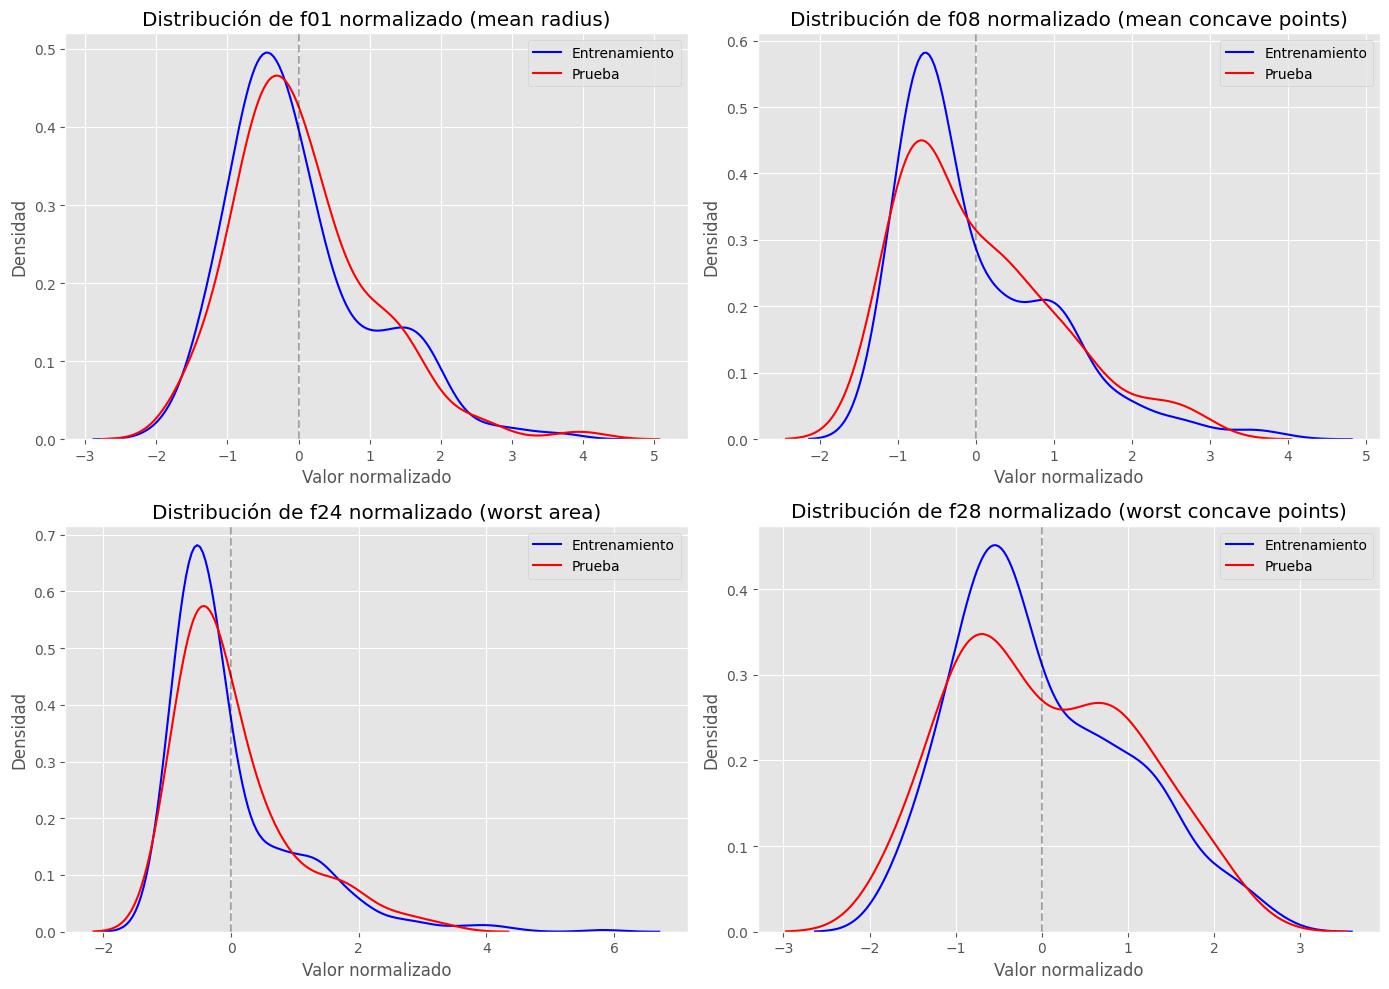

In [10]:
print("\nVerificando la distribución de características normalizadas entre conjuntos...")

# Seleccionar algunas características importantes basadas en análisis previo
important_features = ['f01', 'f08', 'f24', 'f28']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, feature in enumerate(important_features):
    sns.kdeplot(X_train_norm[feature], ax=axs[i], label='Entrenamiento', color='blue')
    sns.kdeplot(X_test_norm[feature], ax=axs[i], label='Prueba', color='red')
    
    axs[i].set_title(f'Distribución de {feature} normalizado ({FEATURE_NAMES[feature]})')
    axs[i].set_xlabel('Valor normalizado')
    axs[i].set_ylabel('Densidad')
    axs[i].axvline(x=0, color='black', linestyle='--', alpha=0.3)
    axs[i].legend()

plt.tight_layout()
plt.savefig('../output/figures/feature_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Resumen del preprocesamiento

In [11]:
print("\n=== Resumen del Preprocesamiento ===")
print(f"Dataset original: {len(df)} muestras, {df.shape[1]} características")
print("\nDivisión de datos:")
print(f"- Entrenamiento: {len(X_train)} muestras ({len(X_train)/len(df):.0%})")
print(f"- Prueba:\t {len(X_test)} muestras ({len(X_test)/len(df):.0%})")

print("\nNormalización:")
print("- Método: Z-score manual (X - media) / desviación estándar")
print("- Estadísticas calculadas SOLO con datos de entrenamiento")
print("- Mismos parámetros aplicados al conjunto de prueba")
print("- Los parámetros de normalización se guardan para uso futuro en la fase de predicción")

print("\nArchivos generados:")
print("- 'train_set_normalized.csv'\t⟶\tCSV con conjunto normalizado de entrenamiento")
print("- 'test_set_normalized.csv'\t⟶\tCSV con conjunto normalizado de prueba")
print("- 'normalization_params.json'\t⟶\tParámetros de normalización")
print("- 'split_params.json'\t\t⟶\tParámetros de división")


=== Resumen del Preprocesamiento ===
Dataset original: 569 muestras, 31 características

División de datos:
- Entrenamiento: 456 muestras (80%)
- Prueba:	 113 muestras (20%)

Normalización:
- Método: Z-score manual (X - media) / desviación estándar
- Estadísticas calculadas SOLO con datos de entrenamiento
- Mismos parámetros aplicados al conjunto de prueba
- Los parámetros de normalización se guardan para uso futuro en la fase de predicción

Archivos generados:
- 'train_set_normalized.csv'	⟶	CSV con conjunto normalizado de entrenamiento
- 'test_set_normalized.csv'	⟶	CSV con conjunto normalizado de prueba
- 'normalization_params.json'	⟶	Parámetros de normalización
- 'split_params.json'		⟶	Parámetros de división
